# Trainsperiment stats

In which I look at data from the trainsperiemtn and pretend that I know how to do exploratory data analysis.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

engine = create_engine('sqlite:///data/train.db')

# Trains since 2021
df = pd.read_sql('''
SELECT
    version,
    datetime(start_time, 'unixepoch'),
    patches,
    max(rollbacks) as rollbacks,
    round(avg(start_time - created),2)/(60*60*24) as cycle_time_days,
    round(avg(start_time - submitted),2)/(60*60*24) as lead_time_days
FROM patch p JOIN train t ON t.id = p.train_id
GROUP BY version
HAVING (lead_time_days > 0 AND cycle_time_days > 0 and lead_time_days < 10 and start_time > 1609484400)
ORDER BY start_time
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df.head()

,version,"datetime(start_time, 'unixepoch')",patches,rollbacks,cycle_time_days,lead_time_days
0,1.36.0-wmf.26,2021-01-12 09:07:09,189,0,27.857665,4.105144
1,1.36.0-wmf.27,2021-01-19 17:59:21,261,2,19.173185,4.206315
2,1.36.0-wmf.28,2021-01-26 18:05:03,286,4,28.593170,4.235773
3,1.36.0-wmf.29,2021-02-02 13:12:33,494,2,24.181736,4.991326
4,1.36.0-wmf.30,2021-02-09 23:57:02,258,1,19.853210,4.210202


Text(0.5, 1.0, 'Patches per Train')

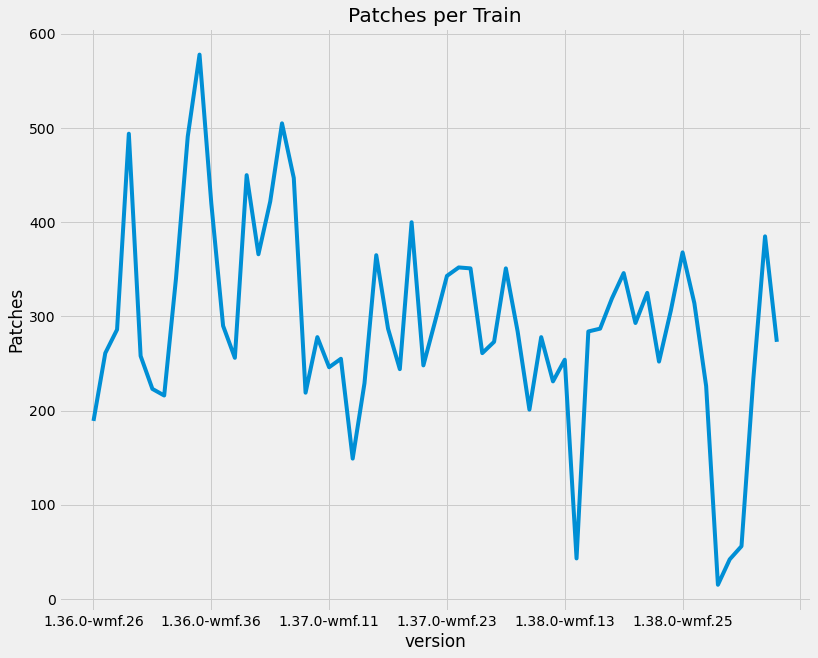

In [3]:
df.set_index('version')['patches'].plot(kind='line', y="lead_time_days", x="version", figsize=(12, 10))
plt.ylabel('Patches')
plt.title('Patches per Train')

Let's find that other dip...

In [4]:
df[df['patches']<100]

,version,"datetime(start_time, 'unixepoch')",patches,rollbacks,cycle_time_days,lead_time_days
41,1.38.0-wmf.16,2022-01-04 22:16:21,43,0,14.654465,2.632745
53,1.39.0-wmf.2,2022-03-21 18:21:39,15,0,89.526682,0.126159
54,1.39.0-wmf.3,2022-03-22 08:51:32,42,0,8.894969,0.250725
55,1.39.0-wmf.4,2022-03-23 17:51:22,56,1,9.353587,0.788044


Ah ha! It seems that that was `1.38.0-wmf.16` which started on Jan 4th, which means it was xmas break 2022.

## Cycle time/Lead time

**Cycle time** is the time from when a patch enters code review to the time that it's in production. **Lead time** is the time it takes from commit to production.

### Lead time

The time from commit to deploy

Text(0.5, 1.0, 'Trainsperiment Lead Time')

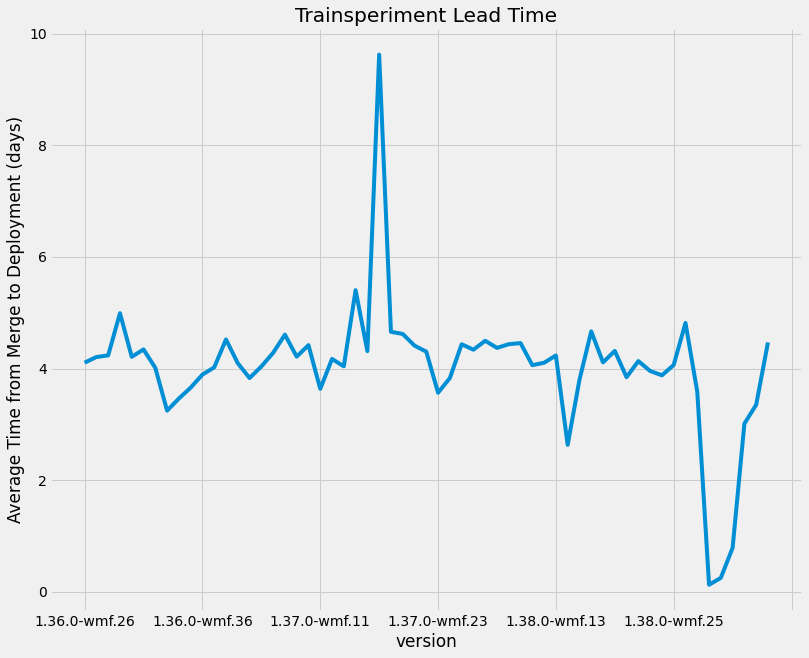

In [5]:
df.set_index('version')['lead_time_days'].plot(kind='line', y="lead_time_days", x="version", figsize=(12, 10))
plt.ylabel('Average Time from Merge to Deployment (days)')
plt.title('Trainsperiment Lead Time')

In [6]:
# GOAL
#         train     lead_time    cycle_time   Id
# 0    1.37.0-wmf.6    200   2000   u1234
# 1    1.37.0-wmf.6    123   2800   u1235
TRAINS = [
    '1.39.0-wmf.1',
    '1.39.0-wmf.2',
    '1.39.0-wmf.3',
    '1.39.0-wmf.4',
]
cycle = pd.read_sql('''
SELECT
    substr(version, 8) as version,
    datetime(start_time, 'unixepoch'),
    (start_time - created)/(60.0*60.0*24.0) as cycle_time_days,
    (start_time - submitted)/(60.0*60.0*24.0) as lead_time_days,
    datetime(created, 'unixepoch'),
    datetime(submitted, 'unixepoch'),
    link
FROM patch p JOIN train t ON t.id = p.train_id
WHERE (lead_time_days > 0 AND cycle_time_days > 0)
    AND (
        version = "%(version_one)s" OR
        version = "%(version_two)s" OR
        version = "%(version_three)s" OR
        version = "%(version_four)s"
    )
''' % {
    'version_one': TRAINS[0],
    'version_two': TRAINS[1],
    'version_three': TRAINS[2],
    'version_four': TRAINS[3],
}, engine)
cycle.head()

,version,"datetime(start_time, 'unixepoch')",cycle_time_days,lead_time_days,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
0,wmf.1,2022-03-21 10:06:50,3.065903,0.493275,2022-03-18 08:31:56,2022-03-20 22:16:31,https://gerrit.wikimedia.org/r/q/771759
1,wmf.1,2022-03-21 10:06:50,3.065903,0.505174,2022-03-18 08:31:56,2022-03-20 21:59:23,https://gerrit.wikimedia.org/r/q/771758
2,wmf.1,2022-03-21 10:06:50,37.350556,0.179398,2022-02-12 01:42:02,2022-03-21 05:48:30,https://gerrit.wikimedia.org/r/q/761969
3,wmf.1,2022-03-21 10:06:50,6.222743,1.259896,2022-03-15 04:46:05,2022-03-20 03:52:35,https://gerrit.wikimedia.org/r/q/770619
4,wmf.1,2022-03-21 10:06:50,5.008900,1.278634,2022-03-16 09:54:01,2022-03-20 03:25:36,https://gerrit.wikimedia.org/r/q/771093


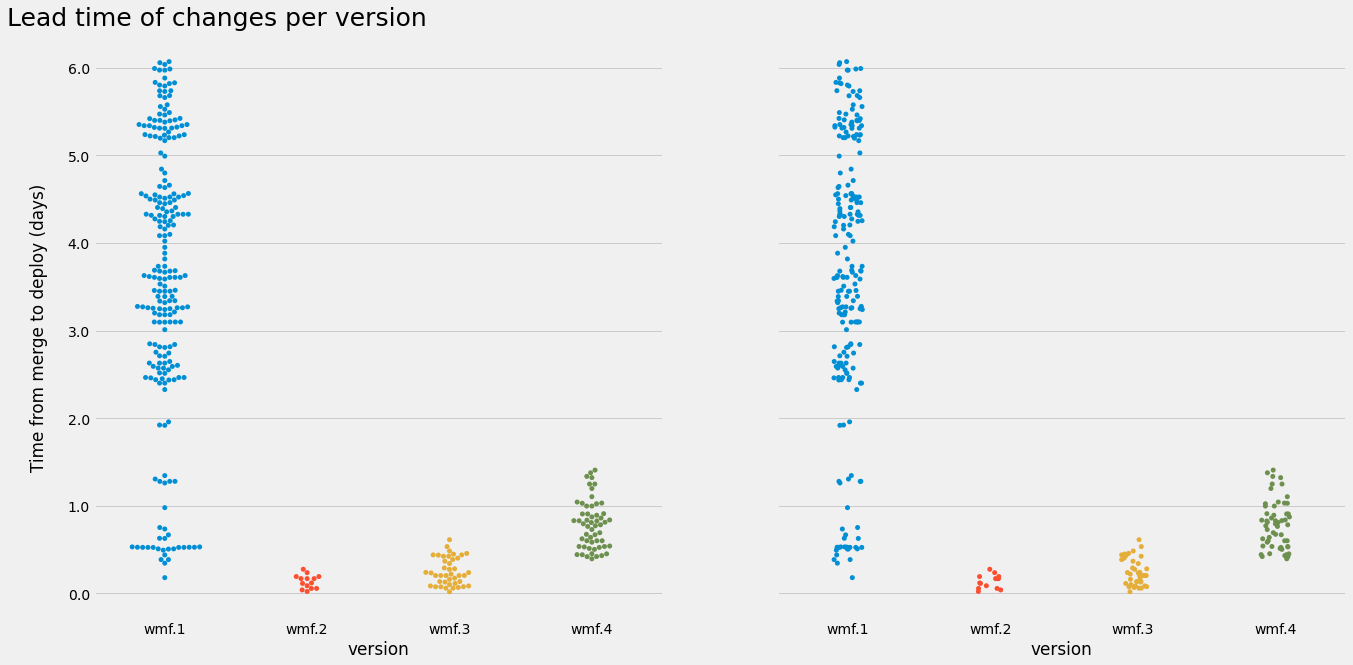

In [11]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20,10))
sns.swarmplot(data=cycle,x='version', y='lead_time_days', ax=ax[0])
sns.stripplot(data=cycle,x='version', y='lead_time_days', ax=ax[1])
ax[1].set_ylabel('')
ax[0].set_ylabel('Time from merge to deploy (days)', labelpad=20.0)
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.suptitle('Lead time of changes per version', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

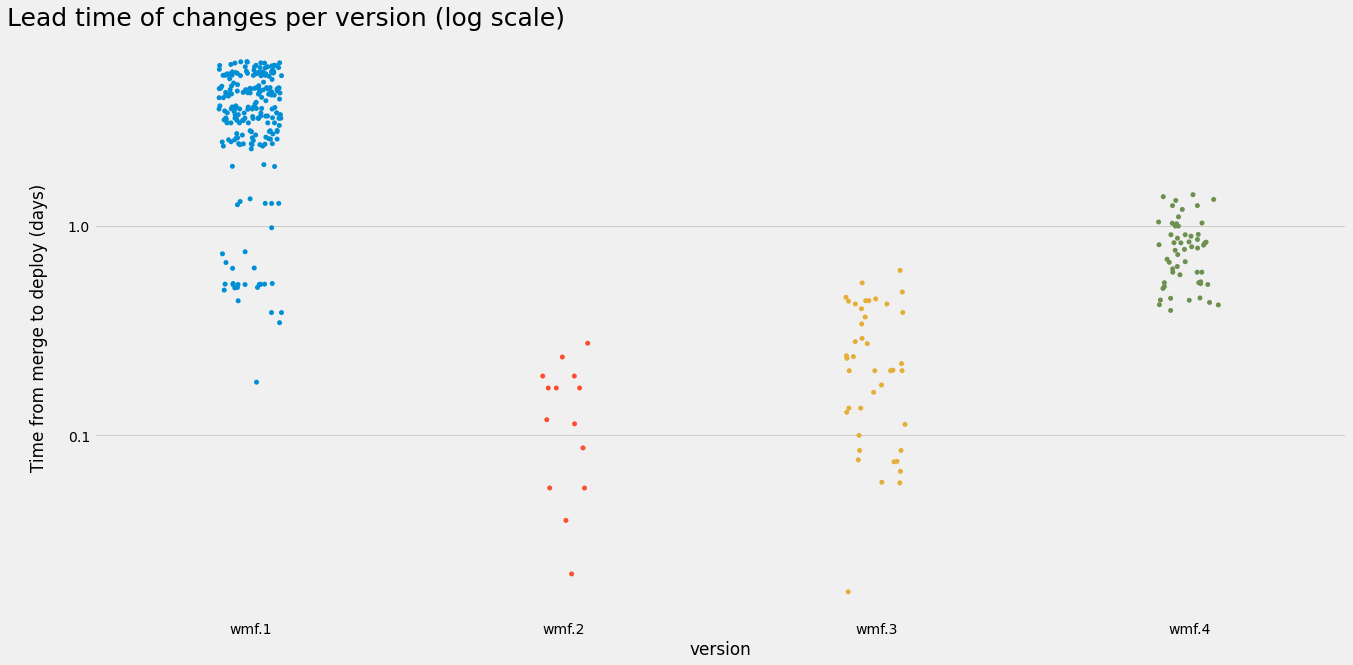

In [13]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(20,10))
ax.set_yscale('log')
sns.stripplot(data=cycle,x='version', y='lead_time_days', ax=ax)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
ax.set_ylabel('Time from merge to deploy (days)', labelpad=20.0)
plt.suptitle('Lead time of changes per version (log scale)', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

### Cycle time

The time from patchset submission for code review to deploy

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 79.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 54.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


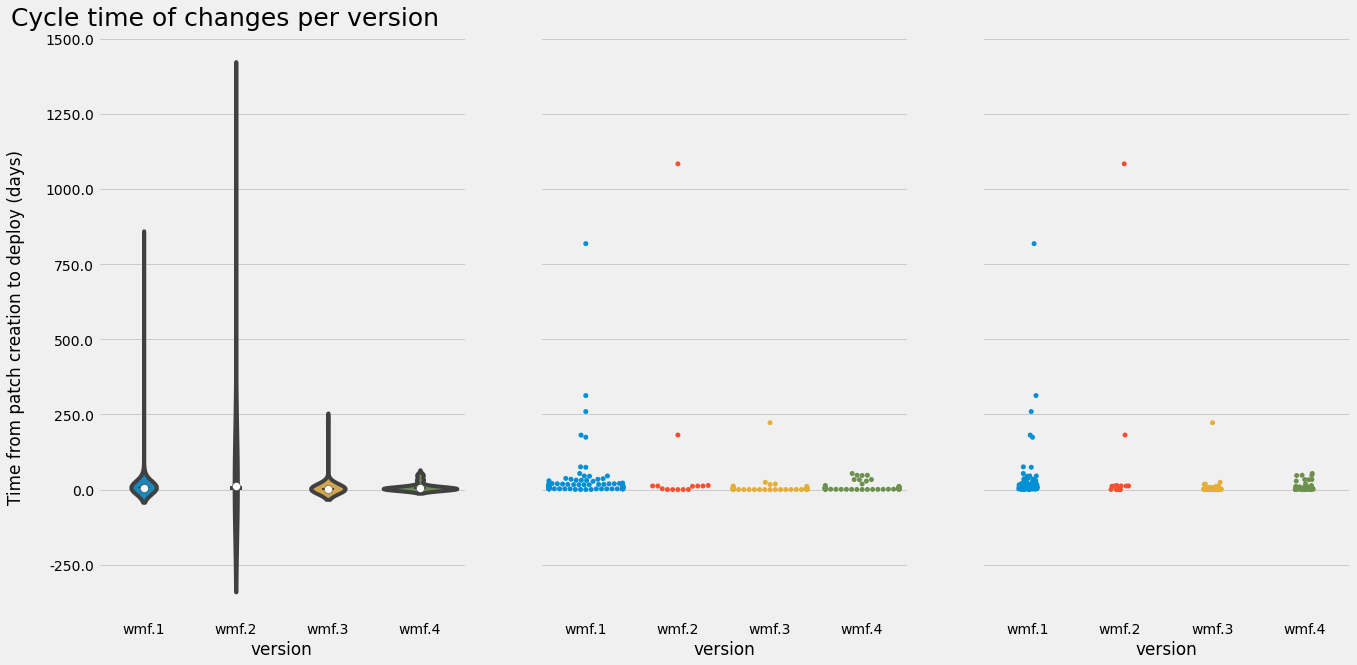

In [14]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))
sns.violinplot(data=cycle,x='version', y='cycle_time_days', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='cycle_time_days', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='cycle_time_days', ax=ax[2])
ax[0].set_ylabel('Time from patch creation to deploy (days)', labelpad=20.0)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.suptitle('Cycle time of changes per version', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

### Cycle time log scale

It's hard to see the majority of our patch's cycletime with the outliers. Here's the log-scale version.

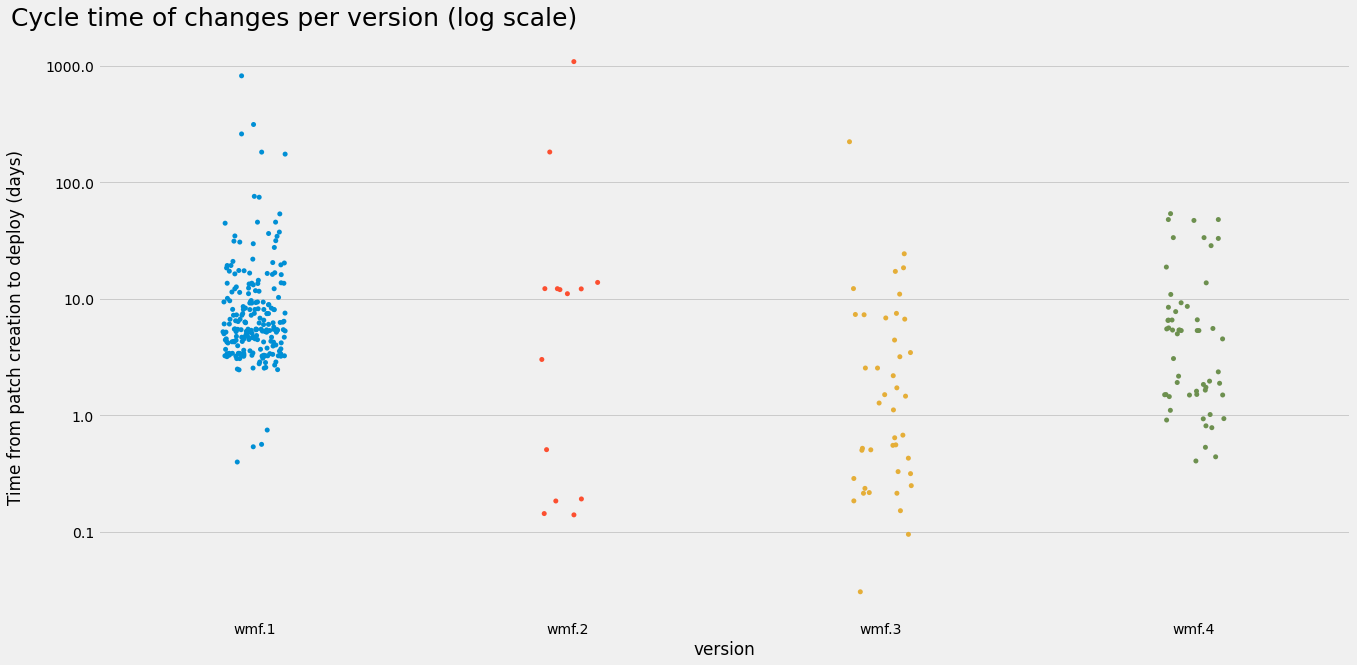

In [15]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(20,10))
ax.set_yscale('log')
sns.stripplot(data=cycle,x='version', y='cycle_time_days', ax=ax)
ax.set_ylabel('Time from patch creation to deploy (days)', labelpad=20.0)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.suptitle('Cycle time of changes per version (log scale)', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()